<a href="https://colab.research.google.com/github/pejmanrasti/EPU_ML_Angers_2023/blob/main/Jour_2/EPU_3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import warnings
import math

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV,RepeatedStratifiedKFold, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score,precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import  RFECV
from sklearn.decomposition import PCA

import pandas as pd
from pandas import read_csv

import numpy as np
from numpy import arange
from numpy import mean
from numpy import std
from numpy import percentile

from matplotlib import pyplot as plt

from imblearn.under_sampling import RandomUnderSampler




**4. Préparer les données**

# Préparation des données pour les algorithmes d'apprentissage

## Import des données

In [ ]:
df = read_csv("/content/DataSet_RegionPelvienne_Class.csv", sep = ",", header=0)
df = df.drop(columns = ["Unnamed: 0"])
df

,MUperGy,MUmax,MUstd,MUiqr,AAV,AAVmin,AAVmax,AAVstd,AAViqr,LSV,...,EMiqr,MIt02,BI,BImin,BImax,BIstd,BIiqr,BM,BAmin,Echec
0,286.279357,0.025226,0.005673,0.007483,0.212154,0.004097,0.470404,0.144776,0.252859,0.940028,...,0.807741,17.169129,5.796453,1.291771,29.291912,7.922034,5.100115,0.680998,0.7750,0
1,286.279357,0.031176,0.009321,0.016940,0.199329,0.004267,0.650373,0.205439,0.346499,0.984624,...,0.794871,15.930889,6.538526,1.281932,27.954796,11.082609,25.520850,0.734694,0.7750,0
2,237.155273,0.015816,0.003171,0.004838,0.363556,0.055128,0.708376,0.197273,0.294814,0.928413,...,0.310386,20.371648,2.415825,0.662184,7.922318,1.369862,1.865898,0.572010,12.9025,0
3,237.155273,0.014917,0.002824,0.005359,0.248252,0.020756,0.655312,0.200993,0.298788,0.996320,...,0.487067,20.240401,3.802425,0.657255,13.165829,2.779706,2.876072,0.704320,4.4525,0
4,273.965837,0.008808,0.001092,0.001163,0.330507,0.151740,0.526259,0.099290,0.141686,0.896153,...,0.529926,9.798427,3.720319,1.435406,8.207767,1.269746,1.936350,0.584751,8.4950,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1328,480.581511,0.026944,0.004214,0.003281,0.204787,0.054245,0.430159,0.109778,0.194116,0.965074,...,0.714579,10.314479,3.957153,0.900998,8.634103,1.723491,2.131027,0.701615,3.6375,1
1329,299.732699,0.009220,0.001537,0.001862,0.285292,0.055741,0.495538,0.101453,0.153115,0.947672,...,0.118663,19.717209,3.161081,1.196474,10.972135,1.735093,0.734561,0.623623,13.1125,0
1330,299.732699,0.015858,0.002611,0.003173,0.256557,0.059329,0.446464,0.105749,0.160722,0.995969,...,0.268859,20.759115,3.689368,1.534641,9.254857,1.624146,1.869984,0.657588,14.6075,0
1331,255.158952,0.012081,0.001707,0.002070,0.391554,0.114153,0.573387,0.093903,0.135343,0.921837,...,0.211482,11.536279,2.869957,1.205563,7.147693,0.954223,0.995646,0.521547,10.3025,0


## Séparation des données
* **Etape très importante** : il faut créer un **jeu de test** que l'on va mettre de côté et ne **jamais** utiliser pendant l'apprentissage.
* Il va servir à calculer l'**erreur de généralisation** : la capacité de notre modèle à faire des prédictions correctes à partir de données inconnues.
* On choisit au hasard entre 20 et 30% des éléments du jeu de données.
* Il faut faire attention à bien **fixer la graine aléatoire** pour ne pas générer un jeu de test différent à chaque execution de la cellule ! Sinon au fur et à mesure l'ensemble du jeu de données aura été utilisé pour l'apprentissage et l'évaluation de la généralisation sera biaisée alors que c'est ce qu'on cherche justement à éviter.
* Pour les jeux de données déséquilibrés, il faut également s'assurer que le jeu de test est représentatif de la répartition de la population dans les données d'origine. Pour cela, il faut réaliser un échantillonnage **stratifié**.   
* Il existe aussi un **jeu de données de validation** issu de la base d'entrainement, sur le même principe que le jeu de test. Il peut être généré avec la méthode de la **cross-validation**.

In [ ]:
y = df['Echec']
z = df.drop('Echec', axis = 1)

#On met de côté les données test qui seront utilisées à la fin
X_train, X_test, Y_train, Y_test = train_test_split(z,y, test_size = 0.3,stratify=y, random_state=2023)

#On enregistre ces données non modifiées (non normalisées, non ré-échantillonnées, non sélectionnées) pour les réutiliser pour exemple dans la suite
X_train_orig = X_train
Y_train_orig = Y_train

In [ ]:
#Répartition des classes
class_counts = pd.DataFrame({'Echec':Y_train}).groupby('Echec').size()
print(class_counts)
print(Y_train.value_counts()/len(Y_train))

Echec
0    830
1    103
dtype: int64
0    0.889603
1    0.110397
Name: Echec, dtype: float64


In [ ]:
#Répartition des classes
class_counts = pd.DataFrame({'Echec':Y_test}).groupby('Echec').size()
print(class_counts)
print(Y_test.value_counts()/len(Y_test))

Echec
0    356
1     44
dtype: int64
0    0.89
1    0.11
Name: Echec, dtype: float64


## Ré-équilibrage des classes
> En classification, les données déséquilibrées posent problème : les algorithmes vont peiner à apprendre sur la classe minoritaire alors que bien souvent c'est précisément la classe qui est la plus importante (comme ici la classe "échec" que l'on souhaite prédire).

> Il y a plusieurs solutions à ce problème :
* Le **sur-échantillonnage** de la classe minoritaire : on crée des exemples artificiels de la classe minoritaire en "interpolant" entre les exemples déjà présents dans cette classe (par exemple avec la technique SMOTE pour Synthetic Minority Over-sampling Technique : sur un exemple "a" aléatoirement choisi de la classe minoritaire, on sélectionne les k plus proches voisins et on choisi l'un d'eux au hasard, le voisin "b". Ensuite, un exemple artificiel est créé aléatoirement entre "a" et "b"). Le problème du sur-échantillonnage, c'est que les exemples artificiels peuvent ne pas être réalistes et ils sont créés sans tenir compte de la classe majoritaire donc on peut se retrouver avec des exemples ambigues qui risquent de biaiser l'apprentissage et détériorer la généralisation.
* Le **sous-échantillonnage** de la classe majoritaire : on supprime aléatoirement des exemples de la classe majoritaire pour diminuer le déséquilibre avec la classe minoritaire. Le principal problème de cette technique est que l'on perd de l'information et qu'on risque de supprimer trop d'informations et donc de ne plus avoir un jeu de données assez représentatif du monde réel. Des techniques plus avancées existent, avec une sélection moins aléatoire des exemples à supprimer ou à garder (Near Miss Undersampling, Condensed Nearest Neighbor Rule, Tomek links, One Sided selection, Neighborhood cleaning rule, etc).
* Combiner le sur et sous-échantillonnage
* L'**apprentissage sensible au coût** qui permet pour certains algorithmes de moduler le poids des faux positifs par rapport aux faux négatifs.


In [ ]:
# Méthode simple : sous-échantillonnage de la classe majoritaire
# Il est possible de moduler le sous-échantillonnage pour seulement réduire le déséquilibre sans pour autant l'annuler complètement en modifiant le paramètre "sampling_strategy"
# Ici on ne supprime pas totalement le déséquilibre pour ne pas supprimer trop d'information
rus = RandomUnderSampler(sampling_strategy={
        0: len(Y_train[Y_train==1])*2,
        1: len(Y_train[Y_train==1])

    }, random_state=2023)
X_train_res, Y_train_res = rus.fit_resample(X_train, Y_train)
# A noter : on ne rééchantillonne que les données d'entrainement pour aider le modèle à apprendre à prédire la classe minoritaire
# Les données test ne sont pas rééchantillonnées, elles doivent rester représentatives de la répartition des données dans le monde réel

# Pour simplifier la suite on transforme les arrays de variables en dataframes
X_train_res = pd.DataFrame(X_train_res, columns = z.columns)
X_test = pd.DataFrame(X_test, columns = z.columns)

class_counts = pd.DataFrame({'Echec':Y_train_res}).groupby('Echec').size()
print(class_counts)

Echec
0    206
1    103
dtype: int64


## Calibrage des variables
* De nombreux algorithmes d'apprentissage automatique fonctionnent moins bien si les variables ont des échelles très différentes.
* Ils existent deux moyens principaux pour passer les variables à la même échelle : **la transformation min-max et la normalisation**
* IMPORTANT : les paramètres de changement d'échelle sont calculées uniquement sur les données d'entrainement et sont seulement appliqués pour calibrer les données test (= ne jamais appliquer de méthode "fit" ou "fit_transform" aux données test).

### Transformation min-max
* Pour chaque variable : on soustrait la valeur min à chaque valeur et on divise par *max - min*
* Les valeurs recalibrées sont toutes comprises entre 0 et 1

In [ ]:
scaler = MinMaxScaler()
X_train_tr = scaler.fit_transform(X_train_res) # calculé et appliqué sur les données d'entrainement
X_test_tr = scaler.transform(X_test) # appliqué sur les données test
pd.DataFrame(X_train_tr).describe()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,...,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,0.403902,0.135899,0.145815,0.160005,0.405878,0.396050,0.501650,0.415512,0.385449,0.722322,...,0.425360,0.314501,0.425204,0.363723,0.275429,0.398174,0.344769,0.294684,0.618216,0.259796
std,0.135393,0.153412,0.152437,0.156292,0.155180,0.165625,0.173713,0.211388,0.207327,0.180962,...,0.203674,0.169141,0.233829,0.174121,0.199183,0.175869,0.162517,0.149357,0.162365,0.206955
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.322449,0.045889,0.049111,0.067146,0.297957,0.264799,0.373981,0.247733,0.225270,0.604711,...,0.283368,0.181851,0.249073,0.238311,0.134109,0.278937,0.232494,0.193064,0.539199,0.107978
50%,0.414388,0.077442,0.105865,0.110369,0.392124,0.389567,0.498728,0.396010,0.350951,0.737022,...,0.398738,0.302515,0.335994,0.334525,0.222233,0.376631,0.325436,0.270715,0.639161,0.182767
75%,0.487159,0.165024,0.179714,0.198367,0.490837,0.516193,0.616051,0.562117,0.516350,0.884799,...,0.563062,0.417898,0.638692,0.462685,0.354762,0.496888,0.424258,0.369699,0.723866,0.382561
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Normalisation
* Pour chaque variable : on soustrait la valeur moyenne et on divise par l'écart-type.
* Les valeurs recalibrées auront une moyenne nulle et un écart-type égal à 1.
* Les valeurs ne sont pas limitées à un intervalle (peut poser problème pour les réseaux de neurones qui attendent souvent des valeurs entre 0 et 1) mais  le résultat est beaucoup moins sensible aux valeurs aberrantes qui peuvent écraser les autres valeurs dans une transformation min-max.

In [ ]:
scaler = StandardScaler()
X_train_tr = scaler.fit_transform(X_train_res) # calculé et appliqué sur les données d'entrainement
X_test_tr = scaler.transform(X_test) # appliqué sur les données test

X_train = scaler.fit_transform(X_train) # normalisation des données non resamplées
X_test = pd.DataFrame(X_test, columns = z.columns)
X_test_tr = pd.DataFrame(X_test_tr, columns = z.columns)

pd.DataFrame(X_train_tr).describe()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
count,3.090000e+02,3.090000e+02,3.090000e+02,3.090000e+02,3.090000e+02,3.090000e+02,3.090000e+02,3.090000e+02,3.090000e+02,3.090000e+02,...,3.090000e+02,3.090000e+02,3.090000e+02,3.090000e+02,3.090000e+02,3.090000e+02,3.090000e+02,3.090000e+02,3.090000e+02,3.090000e+02
mean,4.024109e-16,1.494669e-16,-1.092258e-16,3.449237e-17,-6.898473e-17,9.197964e-17,2.989338e-16,2.644415e-16,8.048219e-17,-3.087067e-15,...,2.529440e-16,-1.954567e-16,1.135374e-16,-2.299491e-16,9.197964e-17,-1.379695e-16,-6.898473e-17,5.748728e-17,4.369033e-16,6.323600e-17
std,1.001622e+00,1.001622e+00,1.001622e+00,1.001622e+00,1.001622e+00,1.001622e+00,1.001622e+00,1.001622e+00,1.001622e+00,1.001622e+00,...,1.001622e+00,1.001622e+00,1.001622e+00,1.001622e+00,1.001622e+00,1.001622e+00,1.001622e+00,1.001622e+00,1.001622e+00,1.001622e+00
min,-2.988020e+00,-8.872778e-01,-9.581132e-01,-1.025419e+00,-2.619778e+00,-2.395121e+00,-2.892496e+00,-1.968829e+00,-1.862151e+00,-3.998035e+00,...,-2.091824e+00,-1.862414e+00,-1.821386e+00,-2.092293e+00,-1.385034e+00,-2.267716e+00,-2.124879e+00,-1.976222e+00,-3.813736e+00,-1.257366e+00
25%,-6.025771e-01,-5.876728e-01,-6.354156e-01,-5.951061e-01,-6.965809e-01,-7.937436e-01,-7.361367e-01,-7.949905e-01,-7.738418e-01,-6.509778e-01,...,-6.982816e-01,-7.855271e-01,-7.544668e-01,-7.214225e-01,-7.106460e-01,-6.790884e-01,-6.919730e-01,-6.814868e-01,-4.874493e-01,-7.347731e-01
50%,7.757555e-02,-3.816622e-01,-2.625030e-01,-3.180983e-01,-8.877354e-02,-3.920535e-02,-1.684822e-02,-9.240943e-02,-1.666644e-01,8.135948e-02,...,-1.309176e-01,-7.098278e-02,-3.821351e-01,-1.679600e-01,-2.675026e-01,-1.226964e-01,-1.191528e-01,-1.607411e-01,1.292046e-01,-3.728049e-01
75%,6.159276e-01,1.901596e-01,2.227378e-01,2.458460e-01,5.483816e-01,7.265647e-01,6.596335e-01,6.946612e-01,6.323979e-01,8.993058e-01,...,6.771914e-01,6.122972e-01,9.144928e-01,5.692729e-01,3.989363e-01,5.622056e-01,4.899025e-01,5.030735e-01,6.517472e-01,5.941608e-01
max,4.409863e+00,5.641687e+00,5.612611e+00,5.383250e+00,3.834823e+00,3.652397e+00,2.873468e+00,2.769489e+00,2.968972e+00,1.536937e+00,...,2.825954e+00,4.059389e+00,2.462176e+00,3.660144e+00,3.643611e+00,3.427573e+00,4.038313e+00,4.730026e+00,2.355201e+00,3.582451e+00


# Mesures de performances en classification binaire

In [ ]:
# Prenons un classifieur simple : la régression logistique
clf = LogisticRegression(solver='lbfgs', random_state = 2023)

# Utilisation de la fonction cross_val_score() pour évaluer le classifieur sur une cross-validation stratifiée à k passes avec k =3
# = le jeu d'entrainement est divisé en 3 blocs, le modèle est entrainé sur 2 blocs et évalué sur le 3ème blocs.
# Le processus est répété 3x jusqu'à ce que chaque bloc ait été utilisé pour l'évaluation
# On obtient un score de performance pour chaque bloc
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=2023)
cross_val_score(clf, X_train, Y_train, cv = cv) # Sur les données non rééquilibrées
# faire le test sur les données non normalisées

array([0.89839572, 0.89839572, 0.90374332, 0.90860215, 0.87096774])

* Par défaut, le score de performance utilisé pour entrainer le modèle sur la CV est l'exactitutde ("accuracy") = proportion de prédictions correctes

* L'exactitude est de près de 90% sur tous les blocs ce qui paraît tout à fait satisfaisant.

Si on définit un classifieur "stupide" qui classe systématiquement les exemples en réussite (0) :

In [ ]:
# classifieur qui classe tous les arcs comme des réussites
from sklearn.base import BaseEstimator

class TjsReussite(BaseEstimator):
  def fit(self, X, y= None):
    pass
  def predict(self, X):
    return(np.zeros((len(X),1), dtype = bool))

clf = TjsReussite()
cross_val_score(clf, X_train, Y_train, cv = cv, scoring = "accuracy") # Sur les données non rééquilibrées

array([0.88770053, 0.88770053, 0.88770053, 0.89247312, 0.89247312])

> Même score que précédemment = l'exactitude ne permet pas de quantifier si notre régression logistique fait mieux que si on classait toutes les observations comme des réussites.

> Exactitude (souvent utilisée par défaut dans les fonctions scikit) = **métrique non adaptée à la classification**, en particulier si la base de données est déséquilibrée.

## Matrice de confusion

In [ ]:
clf = LogisticRegression(solver='lbfgs', random_state = 2023)

#cross_val_predict() est utilisé pour obtenir des prédictions indépendantes pour chaque observation du jeu d'entrainement
# = réalisées par un modèle qui n'a jamais vu ces données pdt l'entrainement
Y_train_pred = cross_val_predict(clf, X_train_tr, Y_train_res, cv=cv)
cm = confusion_matrix(Y_train_res, Y_train_pred)
cm

array([[175,  31],
       [ 37,  66]])

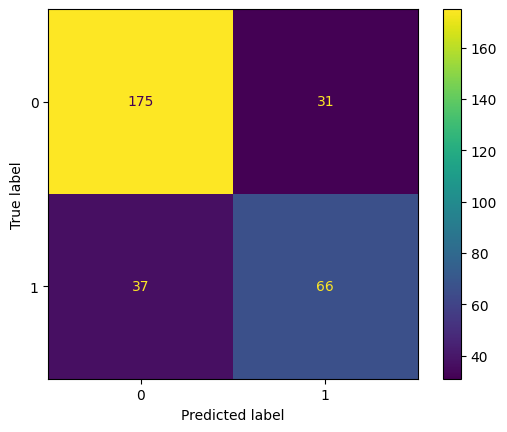

In [ ]:
#Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= [0, 1])
disp.plot()

plt.show()

In [ ]:
# calcul de la sensibilité (ou rappel) à partir du tableau de la matrice de confusion cm[ligne][colonne]
FN = cm[1][0]
TP = cm[1][1]
TPR = TP/(TP+FN)*100
print("Le modèle détecte %0.0f%% des échecs sur les données d'entrainement." %TPR)

Le modèle détecte 64% des échecs.


In [ ]:
# calcul de la spécificité
TN = cm[0][0]
FP = cm[0][1]
TNR = TN/(FP+TN)*100
print("Le modèle détecte %0.0f%% des réussites sur les données d'entrainement." %TNR)

Le modèle détecte 85% des réussites.


In [ ]:
# calcul de la précision
TP = cm[1][1]
FP = cm[0][1]
# PPV pour predicted positive values
PPV = TP / (TP + FP)*100
print("Parmis les échecs détectés sur les données d'entrainement, %0.0f%% sont corrects." %PPV)

Parmis les échecs détectés, 68% sont corrects.


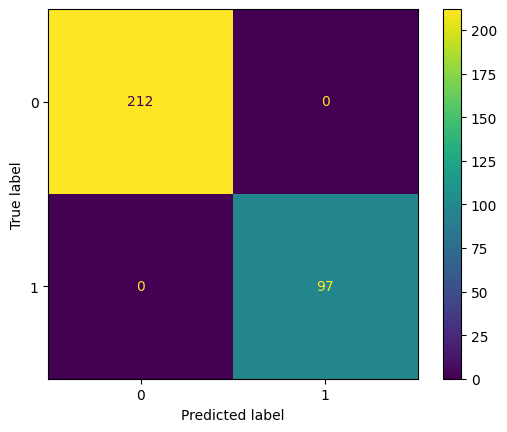

In [ ]:
# Prédictions parfaites
cm = confusion_matrix(Y_train_pred, Y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= [0, 1])
disp.plot()

plt.show()

## Précision et rappel
* Précision : exactitude des prédictions positives = TP / (TP + FP) = TP / Prédits positifs
* Rappel ou sensibilité : proportion de positifs détectés par le classifieur = TP / (TP + FN) = TP / Vrais positifs

In [ ]:
from sklearn.metrics import precision_score, recall_score

prec = precision_score(Y_train_res, Y_train_pred)
print("précision = ", prec)
print("Lorsque le classifieur détecte un arc comme \"échec\", il a raison dans ", round(prec*100, 0), "% des cas")

précision =  0.6804123711340206
Lorsque le classifieur détecte un arc comme "échec", il a raison dans  68.0 % des cas


In [ ]:
rec = recall_score(Y_train_res, Y_train_pred)
print("rappel = ", rec)
print("Le classifieur détecte ", round(rec*100, 0), "% des échecs")

rappel =  0.6407766990291263
Le classifieur détecte  64.0 % des échecs


### Combinaison de la précision et du rappel : score F1
 $$ F1 = 2 \times {précision \times rappel \over précision + rappel} $$
* Moyenne harmonique de la précision et du rappel = contrairement à la moyenne classique, les faibles valeurs ont plus de poids = le score F1 ne sera élevé que si le rappel et la précision le sont

In [ ]:
from sklearn.metrics import f1_score

f1_score(Y_train_res, Y_train_pred)

0.6600000000000001

> Le score F1 favorise une précision et un rappel équivalents.

> Selon les cas on peut chercher à favoriser plutôt la précision ou le rappel

> Notre objectif ici : détecter les arcs susceptibles d'échouer les CQ pour réoptimiser directement les plans à l'étape d'optimisation. On veut éviter de réoptimiser pour rien trop de plans pour ne pas se rajouter du travail inutilement. Donc on souhaite favoriser la précision.

### Compromis entre précision et rappel

In [ ]:
from sklearn.metrics import precision_recall_curve

# Pour chaque observation, l'algorithme calcule un score basé sur une fonction de décision
# Si ce score est supérieur à un seuil prédéfini, il attribue la classe positive à l'observation et sinon la classe négative
# On précise cette fois que l'on souhaite obtenir les scores pour chacune des observations et non les prédictions directement

cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=2023)
Y_scores = cross_val_predict(clf, X_train_tr, Y_train_res, cv=cv, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(Y_train_res, Y_scores)

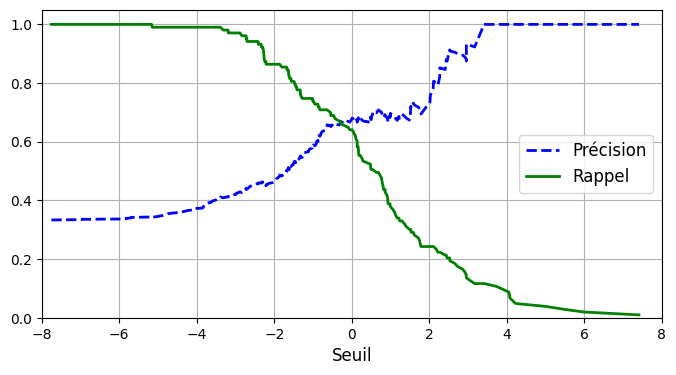

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Précision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Rappel", linewidth=2)
    plt.legend(loc="center right", fontsize=12)
    plt.xlabel("Seuil", fontsize=12)
    plt.grid(True)
    plt.axis([-8, 8, 0, 1.05])



plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

### Courbe PR (précision-rappel)
> On peut également tracer la précision en fonction du rappel

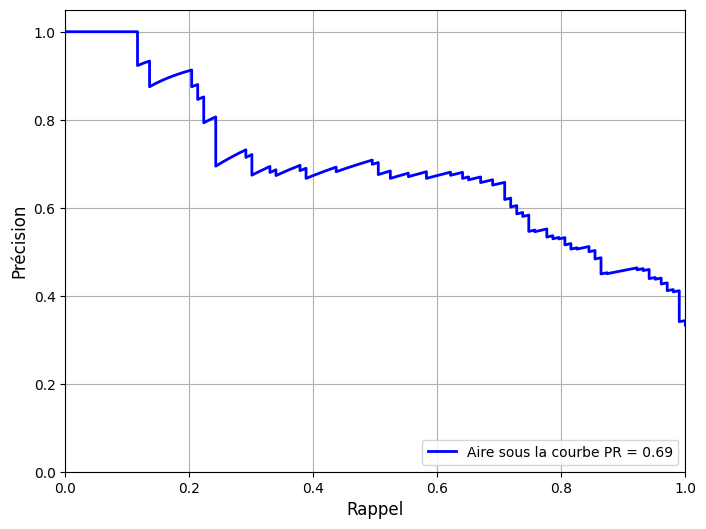

In [ ]:
def plot_precision_vs_recall(precisions, recalls, label = None):
    plt.plot(recalls, precisions, "b-", linewidth=2, label = label)
    plt.xlabel("Rappel", fontsize=12)
    plt.ylabel("Précision", fontsize=12)
    plt.axis([0, 1, 0, 1.05])
    plt.grid(True)
auc_score = metrics.auc(recalls, precisions)
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls, label = "Aire sous la courbe PR = " + str((round(auc_score, 2))))
plt.legend(loc = 'lower right')
plt.show()

## Courbe ROC (courbe d'efficacité du récepteur)
* Métrique la plus couramment utilisée pour estimer et comparer les performances des classifieurs binaires : **aire sous la courbe ROC**
* Taux de vrais positifs en fonction du taux de faux positifs
* Rappel en fonction de 1 - spécificité (1 - TNR)

In [ ]:
from sklearn.metrics import roc_curve

clf = LogisticRegression(solver='lbfgs', random_state = 2023)
Y_scores = cross_val_predict(clf, X_train_tr, Y_train_res, cv=cv, method="decision_function")

fpr, tpr, thresholds = roc_curve(Y_train_res, Y_scores, pos_label = 1)

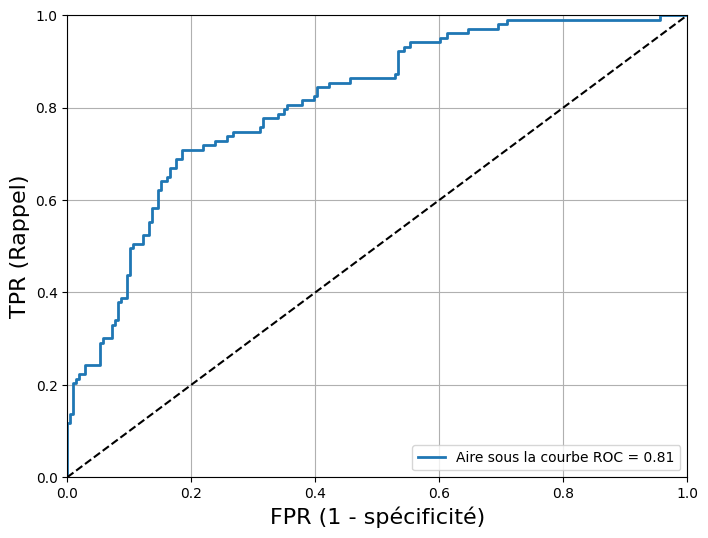

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR (1 - spécificité)', fontsize=16)
    plt.ylabel('TPR (Rappel)', fontsize=16)
    plt.grid(True)
auc = round(roc_auc_score(Y_train_res, Y_scores), 2)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr, label = "Aire sous la courbe ROC = " + str(auc))
plt.legend(loc = 'lower right')
plt.show()



---



---



**5. Evaluer plusieurs modèles**


# Sélection des variables
* La sélection des variables permet de réduire le nombre de variables d'entrée pour à la fois réduire les temps de calcul mais également dans beaucoup de cas améliorer les performances prédictives des modèles
* La présence de variables non-informatives dans le jeu de données peut diminuer la précision des prédictions.
* La présence d'un trop grand nombre de variables dans le jeu de données favorise le sur-ajustement (overfitting) sur les données d'entrainement.

## Méthodes statistiques

### ANOVA
* Analyses de variance
* Test statistique pour déterminer si les moyennes de plusieurs groupes de données (séparés en fonction de données catégorielles, ici les échecs/réussites) proviennent de la même distribution

In [ ]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X_train_tr, Y_train)
X_train_fs = fs.transform(X_train_tr)
X_test_fs = fs.transform(X_test_tr)

Variable 0 MUperGy : 8.099331
Variable 1 MUmax : 0.131904
Variable 2 MUstd : 0.658567
Variable 3 MUiqr : 0.465567
Variable 4 AAV : 18.696460
Variable 5 AAVmin : 6.031456
Variable 6 AAVmax : 7.407047
Variable 7 AAVstd : 2.047182
Variable 8 AAViqr : 1.436841
Variable 9 LSV : 3.262350
Variable 10 LSVmin : 3.143070
Variable 11 LSVmax : 3.568401
Variable 12 LSVstd : 0.712213
Variable 13 LSViqr : 0.894650
Variable 14 AFW : 5.744850
Variable 15 AFWmin : 0.735932
Variable 16 AFWmax : 1.368828
Variable 17 AFWstd : 9.718463
Variable 18 AFWiqr : 6.886543
Variable 19 ALT : 4.327485
Variable 20 CAS : 33.067209
Variable 21 CASmax : 14.526792
Variable 22 CASstd : 0.000036
Variable 23 CASiqr : 0.064177
Variable 24 CLS : 0.643364
Variable 25 CLSmin : 0.577150
Variable 26 CLSmax : 0.343775
Variable 27 CLSstd : 0.002864
Variable 28 CLSiqr : 0.932683
Variable 29 MAD : 1.628577
Variable 30 MADmax : 0.940492
Variable 31 MADstd : 0.869230
Variable 32 MADiqr : 1.102529
Variable 33 MFA : 0.138796
Variable 34 M

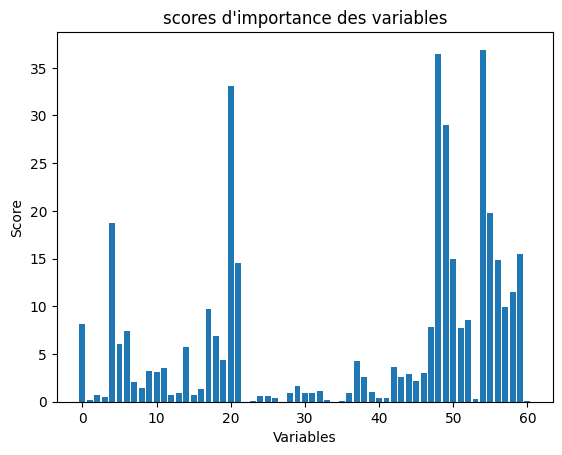

In [ ]:
for i in range(len(fs.scores_)):
  print('Variable %d %s : %f' % (i, z.columns[i], fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title('scores d\'importance des variables')
plt.xlabel('Variables')
plt.ylabel('Score')
plt.show()


In [ ]:
# On ne garde que les 10 meilleures variables par exemple
k_select = 10

fs = SelectKBest(score_func=f_classif, k=k_select)
fs.fit(X_train_tr, Y_train)
X_train_fs = fs.transform(X_train_tr)
X_test_fs = fs.transform(X_test_tr)


(206, 61)

### Information mutuelle
* L'information mutuelle mesure la dépendance entre deux variables

In [ ]:
fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(X_train_tr, Y_train)
X_train_fs = fs.transform(X_train_tr)
X_test_fs = fs.transform(X_test_tr)

Variable 0 MUperGy : 8.099331
Variable 1 MUmax : 0.131904
Variable 2 MUstd : 0.658567
Variable 3 MUiqr : 0.465567
Variable 4 AAV : 18.696460
Variable 5 AAVmin : 6.031456
Variable 6 AAVmax : 7.407047
Variable 7 AAVstd : 2.047182
Variable 8 AAViqr : 1.436841
Variable 9 LSV : 3.262350
Variable 10 LSVmin : 3.143070
Variable 11 LSVmax : 3.568401
Variable 12 LSVstd : 0.712213
Variable 13 LSViqr : 0.894650
Variable 14 AFW : 5.744850
Variable 15 AFWmin : 0.735932
Variable 16 AFWmax : 1.368828
Variable 17 AFWstd : 9.718463
Variable 18 AFWiqr : 6.886543
Variable 19 ALT : 4.327485
Variable 20 CAS : 33.067209
Variable 21 CASmax : 14.526792
Variable 22 CASstd : 0.000036
Variable 23 CASiqr : 0.064177
Variable 24 CLS : 0.643364
Variable 25 CLSmin : 0.577150
Variable 26 CLSmax : 0.343775
Variable 27 CLSstd : 0.002864
Variable 28 CLSiqr : 0.932683
Variable 29 MAD : 1.628577
Variable 30 MADmax : 0.940492
Variable 31 MADstd : 0.869230
Variable 32 MADiqr : 1.102529
Variable 33 MFA : 0.138796
Variable 34 M

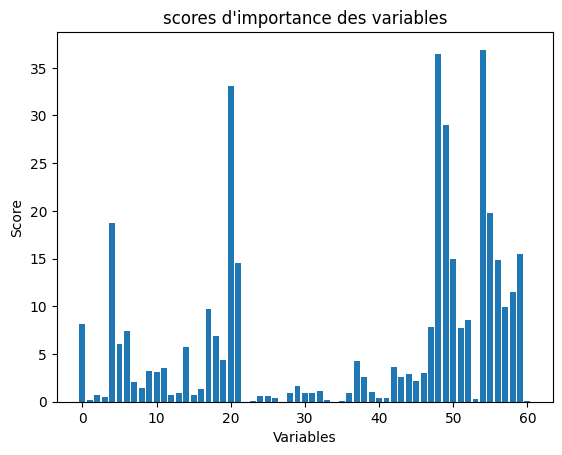

In [ ]:
for i in range(len(fs.scores_)):
  print('Variable %d %s : %f' % (i, z.columns[i], fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title('scores d\'importance des variables')
plt.xlabel('Variables')
plt.ylabel('Score')
plt.show()

### Comment choisir k, le nombre de variable à sélectionner ?
* **Recherche sur grille** : on utilise une validation croisée pour comparer les performances de notre algorithme en fonction de la selection des k meilleures variables, k compris entre 1 et le nombre total de variables.
* On définit un **pipeline** qui est un constructeur permettant séquencer une suite d'étapes à appliquer. Il prend en entrée une liste de paires de nom/estimateur. Tous les estimateurs doivent être des transformateurs ( = comporte une méthode transform() ou fit_transform()) sauf le dernier.  

In [ ]:
#On définit une cross-validation répétée et stratifiée
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=2023)

#On choisit le modèle
model = LogisticRegression(solver='lbfgs')
#fs = SelectKBest(score_func=f_classif) # ANOVA
fs = SelectKBest(score_func=mutual_info_classif) # Information mutuelle

pipeline = Pipeline(steps=[('selection',fs), ('lr', model)])

#On définit la grille de recherche
grille = dict()
grille['selection__k'] = [i+1 for i in range(X_train_tr.shape[1])]

#On définit la grille de recherche pour la cv. On utilise l'aire sous la courbe ROC pour évaluer les performances.
recherche = GridSearchCV(pipeline, grille, scoring='roc_auc', n_jobs=-1, cv=cv)

#On lance la recherche
recherche.fit(X_train_tr, Y_train_res)

# summarize best
print('Meilleur auroc : %.3f' % recherche.best_score_)
print('Meilleurs paramètres : %s' % recherche.best_params_)

Meilleur auroc : 0.823
Meilleurs paramètres : {'selection__k': 28}


0.614299 (0.098818) with: {'anova__k': 1}
0.668993 (0.095463) with: {'anova__k': 2}
0.692406 (0.118302) with: {'anova__k': 3}
0.742855 (0.081657) with: {'anova__k': 4}
0.774722 (0.065333) with: {'anova__k': 5}
0.774162 (0.067860) with: {'anova__k': 6}
0.782483 (0.067266) with: {'anova__k': 7}
0.794838 (0.056569) with: {'anova__k': 8}
0.793630 (0.055984) with: {'anova__k': 9}
0.790552 (0.051396) with: {'anova__k': 10}
0.800320 (0.057138) with: {'anova__k': 11}
0.812360 (0.053231) with: {'anova__k': 12}
0.804887 (0.048017) with: {'anova__k': 13}
0.807311 (0.051077) with: {'anova__k': 14}
0.815844 (0.046255) with: {'anova__k': 15}
0.813548 (0.049049) with: {'anova__k': 16}
0.811628 (0.047554) with: {'anova__k': 17}
0.813142 (0.048161) with: {'anova__k': 18}
0.814312 (0.047282) with: {'anova__k': 19}
0.815551 (0.046899) with: {'anova__k': 20}
0.813305 (0.051658) with: {'anova__k': 21}
0.812379 (0.055441) with: {'anova__k': 22}
0.810465 (0.054629) with: {'anova__k': 23}
0.814271 (0.053485) 

Text(0, 0.5, 'AUROC')

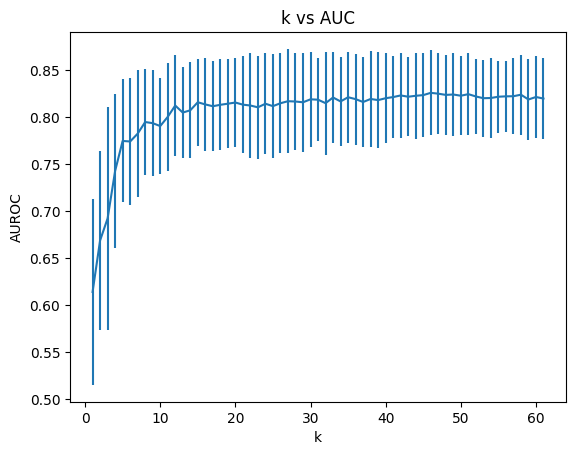

In [ ]:
resultats = recherche.cv_results_
moyennes = resultats['mean_test_score']
variances = resultats['std_test_score']
params = resultats['params']
for moy, var, param in zip(moyennes, variances, params):
    print("%f (%f) with: %r" % (moy, var, param))
# plot
plt.errorbar(grille['anova__k'], moyennes, yerr=variances)
plt.title("k vs AUC")
plt.xlabel('k')
plt.ylabel('AUROC')

> Les techniques ANOVA et information mutuelle posent problème lorsque les données comportent des variables catégorielles (non numériques).

> Autre méthode : RFE

## Réduction de dimension : l'analyse en composantes principales (PCA)
* Objectif : projeter le jeu d'entrainement sur un hyperplan de plus faible dimension
* Il faut sélectionner l'hyperplan qui conserve le plus possible la variance des données afin de perdre moins d'information.
* La technique PCA permet d'identifier les axes (composantes principales) qui contribuent le plus à la variance dans les données d'entrainement.

In [ ]:
from sklearn.decomposition import PCA

# pipeline
steps = [('norm', StandardScaler()), ('pca', PCA(n_components=10)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)

# evaluation du modèle
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=2023)
n_scores = cross_val_score(model, X_train_tr, Y_train_res, scoring='roc_auc', cv=cv, n_jobs=-1)

# performances
print('AUROC: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

AUROC: 0.770 (0.052)


> Taux de variance expliquée :

In [ ]:
pca = PCA(n_components=10)
transformee = pca.fit_transform(X_train_tr)
pca.explained_variance_ratio_

array([0.26088365, 0.15147793, 0.11103855, 0.08626937, 0.053177  ,
       0.04445104, 0.03693762, 0.03406398, 0.0295105 , 0.02659146])

> La variable *explained_variance_ratio_* donne la contribution à la variance de chaque composante principale

> Ici par exemple, 26% de la variance se trouve le long de la 1ère composante, 15% le long de la seconde, ... et moins de 3% pour la 10ème ce qui peut permettre de conclure qu'elle apporte peu d'information.

#### Comment choisir le nombre de dimensions adapté ?
* Pour ne pas choisir arbitrairement le nombre de dimensions, il est recommandé de choisir le nombre de dimensions qui contribuent de manière significative à la variance

In [ ]:
pca = PCA()
pca.fit(X_train_tr)
pca.explained_variance_ratio_
cumsum = np.cumsum(pca.explained_variance_ratio_)
# On calcule le nombre de composantes pour conserver 95% de la variance des données d'entrainement :
d = np.argmax(cumsum >= 0.95) + 1
print("Nombre de dimensions à conserver : ", d)

Nombre de dimensions à conserver :  21


In [ ]:
# Il est aussi possible de le préciser directement dans la fonction PCA()
# Au lieu de donner un entier pour n_components, on donne une valeur réelle entre 0.0 et 1.0
pca = PCA(n_components = 0.95)
X_reduit = pca.fit_transform(X_train_tr)
X_reduit.shape

(309, 21)

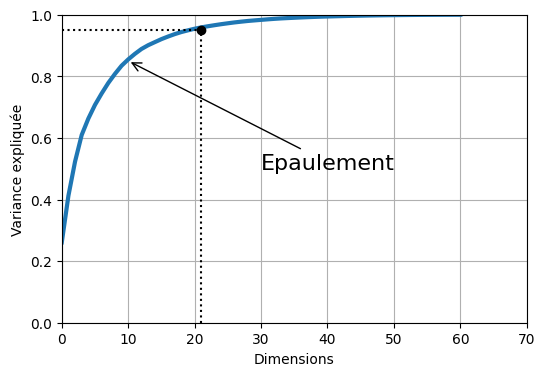

In [ ]:
# On peut aussi tracer la variance en fonction du nombre de dimensions
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 70, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Variance expliquée")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Epaulement", xy=(10, 0.85), xytext=(30, 0.5),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

> L'avantage de cette technique est qu'elle est indépendante de l'algorithme de ML et des données ciblées.

> L'inconvénient de la méthode PCA c'est que pour réaliser une prédiction sur des données nouvelles, il faut partir de la totalité des variables avant d'appliquer la transformation PCA et pouvoir réaliser la prédiction. Dans notre cas, le calcul des PCM peut s'avérer assez long à réaliser (boucles sur les positions de lames du MLC sur tous les points de contrôle). Notre objectif est  aussi de réduire ces temps de calcul pour que l'opérateur n'ait pas à attendre trop longtemps pour réaliser une prédiction.

## Elimination récursive des variables (RFE - Recursive Feature Elimination)
* Un algorithme est d'abord entrainé avec la totalité des variables. Un score de performance est calculé. La variable de moindre importance est supprimée et l'algorithme réentrainé. Le nouveau score est comparé au précédent. Le processus est répété jusqu'à ce qu'il ne reste qu'un nombre défini de variable. Les scores de performance obtenus à chaque itération sont comparés pour déterminer le nombre de variables à sélectionner.  
* Facile à implémenter
* Deux paramètres à définir : nombre de variables minimal à sélectionner et algorithme à utiliser pour choisir les variables

In [ ]:
%%time

from sklearn.feature_selection import  RFECV


#Score utilisé pour sélectionner les variables
def AUC(clf, X, y_true):
    y_pred_proba = clf.predict_proba(X)
    return  roc_auc_score(y_true, y_pred_proba[:, 1])

#Paramétrage de la régression logistique
LR = Pipeline([('scale', StandardScaler()),
                               ('clf', LogisticRegression(solver='lbfgs'))])
#Paramétrage de la cross-validation
kfold = RepeatedStratifiedKFold(n_splits=3, n_repeats = 3, random_state=2023)

# Nombre minimum de variables à considérer lors du process d'élimination récursif
min_features_to_select = 1

#Process d'élimination récursif avec CV

rfecv_LR = RFECV(
    estimator=LR,
    step=1, # nombre de variables à supprimer à chaque itération
    cv=kfold,
    scoring=AUC,
    min_features_to_select=min_features_to_select,
    importance_getter="named_steps.clf.coef_" # commande pour récupérer la classification des variables par l'estimateur
)



rfecv_LR.fit(X_train_res, Y_train_res)


CPU times: user 9.83 s, sys: 5.11 s, total: 14.9 s
Wall time: 11.2 s


RFECV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=2023),
      estimator=Pipeline(steps=[('scale', StandardScaler()),
                                ('clf', LogisticRegression())]),
      importance_getter='named_steps.clf.coef_',
      scoring=<function AUC at 0x7f330e0dc3a0>)

In [ ]:
#Sélection RFE
mask = rfecv_LR.support_
X_train_rfe = X_train_res.loc[:, mask]
X_test_rfe = X_test.loc[:, mask]
print("Nombre de variables sélectionnées par le process : ",rfecv_LR.n_features_ )
print("Variables sélectionnées : ",list(X_train_rfe.columns) )

Nombre de variables sélectionnées par le process :  8
Variables sélectionnées :  ['AAVmin', 'ALT', 'CAS', 'MFAstd', 'SAS2max', 'SAS10max', 'EM', 'MIt02']


In [ ]:
# Comme le résultat de RFE dépend de l'algorithme choisi, on peut vouloir reproduire le processus pour différents algo.
# On peut donc définir une fonction qui retourne le masque de sélection des variables
def RFEselection(X, Y, clf, importance_getter="named_steps.clf.coef_") :
  model = Pipeline([('scale', StandardScaler()),
                                ('clf', clf)])
  #Paramétrage de la cross-validation
  kfold = StratifiedKFold(n_splits=3)

  def AUC(clf, X, y_true):
    y_pred_proba = clf.predict_proba(X)
    return  roc_auc_score(y_true, y_pred_proba[:, 1])

  # Nombre minimum de variables à considérer lors du process d'élimination récursif
  min_features_to_select = 1

  #Process d'élimination récursif avec CV

  rfecv_LR = RFECV(
      estimator=model,
      step=1,
      cv=kfold,
      scoring=AUC,
      min_features_to_select=min_features_to_select,
      importance_getter=importance_getter
  )



  rfecv_LR.fit(X, Y)

  mask = rfecv_LR.support_

  return mask

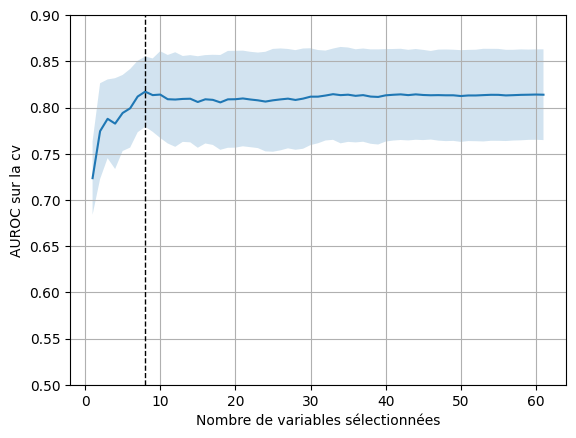

In [ ]:
x = range(1, 62)
y =  rfecv_LR.cv_results_['mean_test_score']
error = rfecv_LR.cv_results_['std_test_score']
plt.plot(x, y)
plt.fill_between(x, y-error, y+error,alpha=.2)
plt.axvline(rfecv_LR.n_features_, color='black', linestyle='dashed', linewidth=1)
plt.xlabel("Nombre de variables sélectionnées")
plt.ylabel("AUROC sur la cv")
plt.ylim(0.5, 0.9)
plt.grid(True)
plt.show()

 *Pour aller plus loin : relancer RFE en modifiant les paramètres de la CV ou en modifiant l'algorithme utilisé ou encore en demandant un autre score de performance (voir https://scikit-learn.org/stable/modules/model_evaluation.html). Coder une cellule où on utilise la fonction qui a été définie pour rfe*

# Entrainement
* On va chercher à déterminer les meilleurs **hyper-paramètres** pour notre modèle
* Chaque algorithme comporte un ou plusieurs hyper-paramètres optimisables.
* Les hyper-paramètres sont **ajustables par l'utilisateur** et controlent le processus d'apprentissage (exemple : force de la régularisation pour une régression logistique ou le nombre d'arbres pour une forêt aléatoire)
* Ils diffèrent des paramètres internes du modèle qui sont "appris" pendant l'entrainement sur les données (par exemple les coefficients dans une régression logistique)
* Les hyper-paramètres d'un modèle interagissent entre eux de manière non linéaire. Différentes combinaisons d'hyper-paramètres peuvent mener à des performances différentes du modèle sur un même jeu de données.
* Pour déterminer les meilleurs hyper-paramètres, on peut utiliser :
  * une **recherche sur grille** (grid search) : on définit un espace de recherche pour chacun des hyper-paramètres et on teste toutes les combinaisons.
  * une **recherche sur grille aléatoire** (randomized grid search) : on sélectionne aléatoirement une certain nombre de combinaisons dans l'espace de recherche. On peut passer à côté des meilleures combinaisons mais cela permet de contrôler les temps de calcul.
  * une *recherche en demi grille* (Halving grid search) : la recherche est d'abord effectuée sur un échantillon des données d'entrainement, les meilleures combinaisons sont sélectionnées et testées sur un échantillon plus grand, etc.
* La recherche sur grille des hyper-paramètres est réalisée via une **cross-validation (CV)** : pour chaque combinaison d'hyper-paramètres évaluée on va estimer les performances du modèles sur les folds de validation de la CV.


*Rappel*
* *X_train_tr : variables d'entrainement rééchantillonnées et normalisées*
* *X_test_tr : variables test normalisées*
* *X_train_res : variables d'entrainement rééchantillonnées et non normalisées*
* *X_train_orig et X_test_orig : variables d'entrainement et test non modifiées*
* *Y_train_res : cibles des données d'entrainement rééchantillonnées*
* *Y_test : cibles des données test*

### Régression logistique

In [ ]:
%%time

# Scores utilisés pendant la CV
# Certains sont déjà codés dans scikit (https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score)
# Mais on peut les personnaliser via la fonction make_scorer de scikit (voir doc scikit) ou en définissant ce type de fonction :
def AUC(clf, X, y_true):
  #Aire sous la courbe ROC
    y_pred_proba = clf.predict_proba(X)
    return  roc_auc_score(y_true, y_pred_proba[:, 1])

def AUPRC(clf, X, y_true):
  #Aire sous la courbe PR
    y_pred_proba = clf.predict_proba(X)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba[:, 1])
    auc_score = metrics.auc(recall, precision)
    return (auc_score)

# On crée un dictionnaire des métriques qu'on veut évaluer :
metriques = {"AUPRC": AUPRC,
        "AUROC": AUC,
             "ACCURACY" : "accuracy"}


# On définit le classifieur :
clf = LogisticRegression(solver='lbfgs', random_state = 2023)

# On lance RFE sur les données d'entrainement non normalisées (car la normalisation est faite via le pipeline défini dans la fonction)
mask = RFEselection(X_train_res, Y_train_res, clf, importance_getter="named_steps.clf.coef_")
# On l'applique sur les données non normalisées (car utilisation d'un pipeline avec normalisation pour l'entrainement du modèle)
X_train_rfe = X_train_res.loc[:, mask]
X_test_rfe = X_test.loc[:, mask]

# On définit les paramètres du modèle
LR =  {
            #Pipeline qui permet de normaliser les données d'entrainement des folds de la CV avant d'entrainer le modèle dessus
            'model': Pipeline([('scale', StandardScaler()),
                               ('clf', clf)]),
            'params': {
            # C = force de la régularisation. Plus C est petit, plus la régularisation est forte
            # La régularisation permet de limiter la complexité du modèle et donc de limiter le sur-apprentissage
            'clf__C': [0.05, 0.1, 0.5, 0.8, 1, 3, 5, 7, 10, 12, 15]

        }
        }

# Pour définir le nombre de processeurs qu'on souhaite utiliser pour la recherche sur grille
# Cette commande permet de ne pas utiliser tous les processeurs et de pouvoir travailler par ailleurs sur le PC en question pendant la recherche si celle-ci est longue
# jobs = os.cpu_count()-2

#CV à 3 folds répétée 5 fois
kfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=2023)


#Gridsearch des hyperparamètres
clf = GridSearchCV(LR['model'],
                           LR['params'],
                           cv=kfold,
                           return_train_score=False,
                           scoring=metriques, # Pour le scoring on donne le dictionnaire, ça permet de calculer plusieurs scores pour chaque itération de la CV
                           refit = "AUROC", # Dans ce cas, il faut préciser que la recherche des meilleurs hyperparamètres se fait en fonction de l'AUROC
                           error_score="raise",
                           n_jobs=-1 # -1 signifie qu'on souhaite utiliser tous les processeurs. Cela peut bloquer le PC le temps de la recherche.
                            )

# On utilise les variables sélectionnées avec RFE
# Attention elles ne doivent pas être normalisées, elles le seront via le pipeline, sinon risque de fuite de données lors de CV
# fuite de données = la moyenne et l'écart-type utilisés pour la normalisation auront "vu" les données de validation si on fait la normalisation en amont de la CV
# = les scores calculés sur les données de validation pdt la CV risquent d'être biaisés de façon optimiste
# On lance la recherche à partir des données d'entrainement :
clf.fit(X_train_rfe, Y_train_res)

# On stocke les résultats de la recherche dans la variable results.
# C'est un dictionnaire qui contient les scores obtenus à chaque itération de la CV pour chaque combinaison d'hyperparamètres, les scores moyens, l'écart-type
# et le classement des scores obtenus sur chaque CV pour chacune des combinaisons testées.
results = clf.cv_results_

# np.nonzero retourne les indices des éléments non nuls dans chaque dimension d'un array.
# ici il renvoit les indices des éléments non nuls de la liste results["rank_test_AUROC"]
# results["rank_test_AUROC"] donne le classement des résultats AUROC pour chaque combinaison testée
# dans best_index on stocke le numéro d'index de la meilleure combinaison d'hyperparamètres
best_index = np.nonzero(results["rank_test_AUROC"] == 1)[0][0]

# On paramètre le modèle final avec cette combinaison et on l'entraine sur les données d'entrainement
model_final =  LR['model'].set_params(**results["params"][best_index]).fit(X_train_rfe, Y_train_res)

# On enregistre dans Y_proba_LR la probabilité prédite par le modèle d'appartenir à l'une ou l'autre des classes
# On préfère enregistrer les probabilités plutôt que directement les classes prédites
# Cela permet ensuite de moduler la précision et le rappel en modifiant le seuil de décision de cette probabilité
# Y_proba_LR est un tableau à 2 colonnes, la 1ère colonne donne les probabilité d'appartenir à la classe 0 et la seconde à la classe 1.
Y_proba_LR = model_final.predict_proba(X_test_rfe)

# On peut aussi prédire directement les classes, mais par défaut le seuil de probabilité est 50%
Y_pred_LR = model_final.predict(X_test_rfe)

CPU times: user 6.2 s, sys: 3.17 s, total: 9.37 s
Wall time: 27.9 s


*Pour aller plus loin : faire le test sans normaliser les données*

In [ ]:
# Si on veut visualiser les résultats de la cv sous forme de tableau (les lignes sont classées par AUROC moyen décroissant) :
cv_results = pd.DataFrame(results).sort_values("mean_test_AUROC", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,params,split0_test_AUPRC,split1_test_AUPRC,split2_test_AUPRC,split3_test_AUPRC,...,split2_test_ACCURACY,split3_test_ACCURACY,split4_test_ACCURACY,split5_test_ACCURACY,split6_test_ACCURACY,split7_test_ACCURACY,split8_test_ACCURACY,mean_test_ACCURACY,std_test_ACCURACY,rank_test_ACCURACY
5,0.104113,0.020669,0.062433,0.035145,3,{'clf__C': 3},0.656038,0.744312,0.745569,0.691158,...,0.786408,0.825243,0.893204,0.728155,0.708738,0.815534,0.786408,0.786408,0.051780,7
4,0.087034,0.015380,0.055324,0.011669,1,{'clf__C': 1},0.667756,0.752804,0.742902,0.704825,...,0.796117,0.825243,0.873786,0.737864,0.757282,0.796117,0.786408,0.795038,0.036455,2
6,0.241359,0.044973,0.112032,0.030520,5,{'clf__C': 5},0.653037,0.739786,0.741150,0.675286,...,0.796117,0.825243,0.883495,0.747573,0.708738,0.805825,0.786408,0.787487,0.047661,6
3,0.076683,0.013975,0.051091,0.006486,0.8,{'clf__C': 0.8},0.670106,0.759146,0.736895,0.710960,...,0.786408,0.825243,0.873786,0.747573,0.766990,0.796117,0.776699,0.795038,0.034385,2
7,0.146021,0.028807,0.041124,0.019926,7,{'clf__C': 7},0.655212,0.738865,0.734333,0.672890,...,0.796117,0.805825,0.873786,0.747573,0.699029,0.805825,0.786408,0.782093,0.048243,8


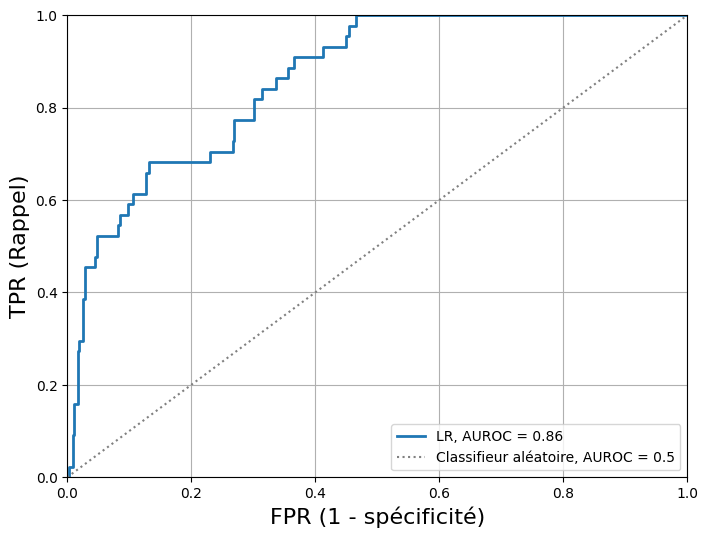

In [ ]:
# Comme on va souvent vouloir afficher des courbes ROC, on peut définir une fonction afin de ne pas répéter toujours les mêmes commandes
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], linestyle='dotted', color = 'grey', label = 'Classifieur aléatoire, AUROC = 0.5')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR (1 - spécificité)', fontsize=16)
    plt.ylabel('TPR (Rappel)', fontsize=16)
    plt.grid(True)

# Attention pour calculer la courbe ROC il faut toujours utiliser les probabilités et non les classes prédites.
# Ici on s'intéresse à la classe 1 donc on utilise les probabilités de la seconde colonne de Y_proba_LR
auc_lr = round(roc_auc_score(Y_test, Y_proba_LR[:, 1]), 2)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(Y_test, Y_proba_LR[:, 1])
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_lr, tpr_lr, label = "LR, AUROC = " + str(auc_lr))
plt.legend(loc = 'lower right')
plt.show()

*Pour aller plus loin : tracer la courbe de précision/rappel.*

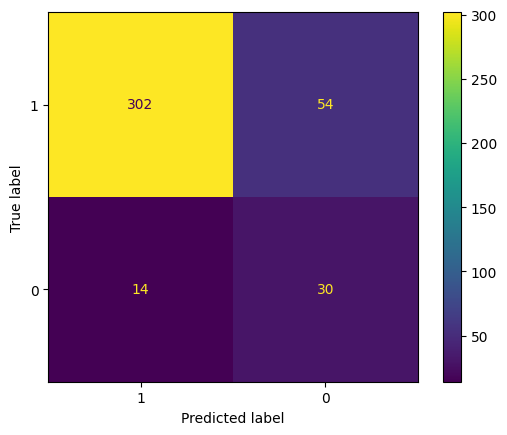

In [ ]:
# Résultats prédits en fonction du seuil de décision
seuil = 0.5
y_pred = np.where(Y_proba_LR[:, 1] > seuil, 1, 0)

cm = confusion_matrix(Y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels = [1, 0])

cm_display.plot()
plt.show()

*Pour aller plus loin : évaluer l'impact de la modification du seuil de décision sur la matrice*

Evaluer l'impact du paramètre C sur les résultats, pour les deux métriques demandées pendant la CV :

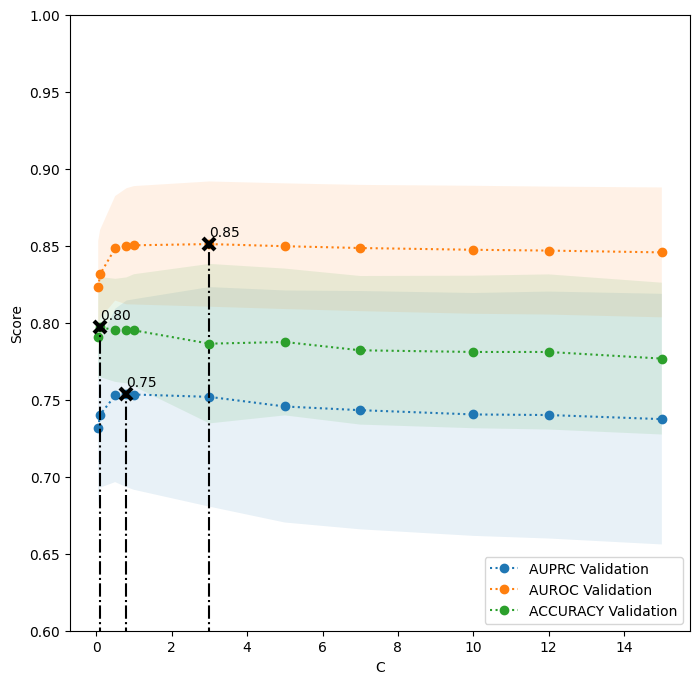

In [ ]:
# On part d'une figure dont on définit la dimension
plt.figure(figsize=(8, 8))

# On définit le nom des axes
plt.xlabel("C")
plt.ylabel("Score")

# On récupère les axes dans ax, ce qui permet de paramétrer leurs limites si besoin (si les limites par défaut ne conviennent pas)
ax = plt.gca()
#ax.set_xlim(0, 10)
ax.set_ylim(0.6, 1)

# On récupère les valeurs testées pour C dans la CV
X_axis = np.array(results["param_clf__C"].data, dtype=float)

# Pour les métriques utilisées pdt la CV (stockées dans le dico metriques plus haut)
for scorer in metriques:
      # On stocke le résultat moyen de la CV obtenu sur les données de validation (étiquetées comme "test" dans la CV)
      sample_score_mean = results["mean_test_%s" % scorer]
      # et l'écart type
      sample_score_std = results["std_test_%s" % scorer]
      # On remplit l'affichage autour de la courbe du score moyen à +- un écart type
      ax.fill_between(
          X_axis,
          sample_score_mean - sample_score_std,
          sample_score_mean + sample_score_std,
          alpha=0.1
      )
      # On trace le score moyen
      ax.plot(
          X_axis,
          sample_score_mean,
          ":o",
          alpha=1,
          label="%s Validation" % scorer,
      )

      best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
      best_score = results["mean_test_%s" % scorer][best_index]

      # On trace une ligne verticale pour le meilleur paramètre et on le note avec un x
      ax.plot([X_axis[best_index],]* 2,[0, best_score],linestyle="-.",color = "black", marker="x",markeredgewidth=3,ms=8,)

      # On annote avec le score correspondant
      ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="lower right")
plt.show()

Pour aller plus loin : ajouter une métrique, par exemple le score f1.

### Forêt aléatoire
On peut refaire la même chose avec un autre algorithme, par exemple une **forêt aléatoire** :

In [ ]:
%%time

clf = RandomForestClassifier(criterion = 'gini',max_features = 'sqrt',class_weight = 'balanced')

# Sélection RFE
# Importance_getter définit la façon dont RFE va aller chercher la classification des variables via l'algo.
# Selon les algos, la classification est codée avec la commande coef_ ou feature_importances_ dans la definition de l'algo
# Sans pipeline, le choix est fait en automatique si on ne précise rien
# Avec les pipeline, il faut préciser ce choix manuellement
# Pour le savoir, il faut bien lire la doc associée aux fonctions https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
mask = RFEselection(X_train_res, Y_train_res, clf, importance_getter="named_steps.clf.feature_importances_")
X_train_rfe = X_train_res.loc[:, mask]
X_test_rfe = X_test.loc[:, mask]

#Paramètres du modèle
RF =  {
            'model': Pipeline([('scale', StandardScaler()),
                               ('clf', clf)]),
            'params': {
            #'clf__n_estimators': [100, 120, 150],
            'clf__max_depth' : [1, 2, 4, 6, 8, 10, 12, 20, 30, 40],

        }
        }



#CV
kfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=2023)


#Gridsearch des hyperparamètres
clf = GridSearchCV(RF['model'],
                           RF['params'],
                           cv=kfold,
                           return_train_score=False,
                           scoring=metriques,
                           refit = "AUROC",
                           error_score="raise",
                           n_jobs=-1)

#On utilise les variables sélectionnées avec RFE
# Attention elles ne doivent pas être normalisées, elles le seront via le pipeline, sinon risque de fuite de données
clf.fit(X_train_rfe, Y_train_res)
results = clf.cv_results_
best_index = np.nonzero(results["rank_test_AUROC"] == 1)[0][0]
model_final =  RF['model'].set_params(**results["params"][best_index]).fit(X_train_rfe, Y_train_res)
Y_proba_RF = model_final.predict_proba(X_test_rfe)

CPU times: user 54.1 s, sys: 108 ms, total: 54.2 s
Wall time: 1min 4s


Pour évaluer l'impact d'un hyper-paramètres sur les résultats de la CV :

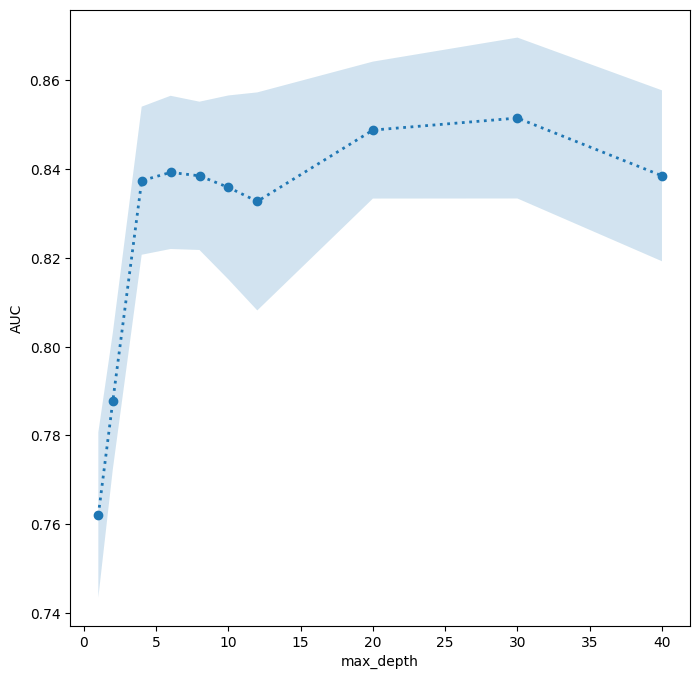

In [ ]:
# On part d'une figure dont on définit la dimension
param = "max_depth"
Xaxis = np.array(results["param_clf__%s" % param].data, dtype=float)
mean_score = results["mean_test_AUROC"]
std_score = results["std_test_AUROC"]
plt.figure(figsize=(8, 8))

# On définit le nom des axes
plt.xlabel(param)
plt.ylabel("AUC")

#Trace une courbe avec les barres d'erreur
plt.plot(Xaxis, mean_score,":o", linewidth=2, label=param)
plt.fill_between(
            Xaxis,
            mean_score - std_score,
            mean_score + std_score,
            alpha=0.2,

        )
plt.show()

autre type d'affichage :

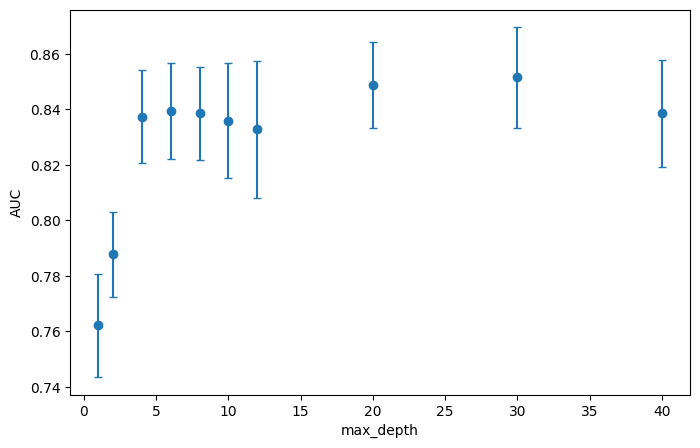

In [ ]:
# On part d'une figure dont on définit la dimension
param = "max_depth"
Xaxis = np.array(results["param_clf__%s" % param].data, dtype=float)
mean_score = results["mean_test_AUROC"]
std_score = results["std_test_AUROC"]
plt.figure(figsize=(8, 5))

# On définit le nom des axes
plt.xlabel(param)
plt.ylabel("AUC")

plt.errorbar(Xaxis, mean_score, yerr=std_score, fmt='o', capsize=3, capthick=1)
plt.show()

*Pour aller plus loin : évaluer l'impact des autres hyper-paramètres de RF sur les performances*

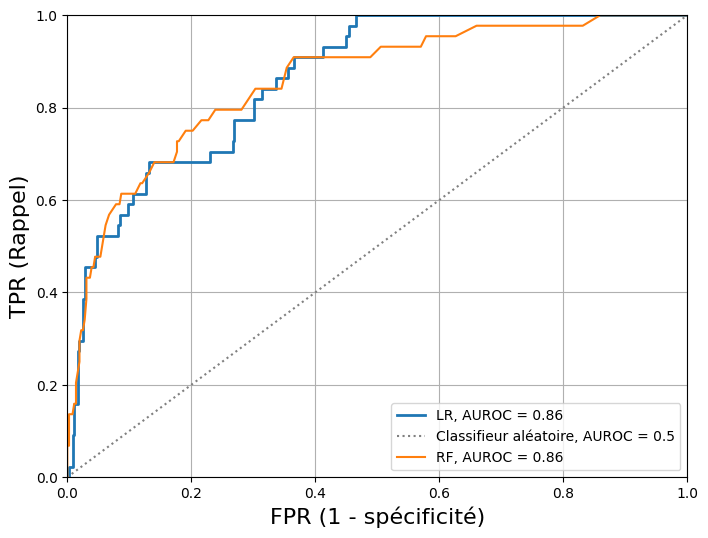

In [ ]:
# On peut comparer les deux modèles, LR et RF, sur les données test
auc_rf = round(roc_auc_score(Y_test, Y_proba_RF[:, 1]), 2)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, Y_proba_RF[:, 1])
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_lr, tpr_lr, label = "LR, AUROC = " + str(auc_lr))
plt.plot(fpr_rf, tpr_rf, label = "RF, AUROC = " + str(auc_rf))
plt.legend(loc = 'lower right')
plt.show()

Pour aller plus loin : faire de même avec la courbe de précision/rappel